In [119]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Annotated,Literal
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from pydantic import BaseModel,Field
import operator
import os   
load_dotenv()

True

In [120]:
model = ChatGoogleGenerativeAI(model="gemini-2.0-flash",
    api_key=os.getenv("GOOGLE_API"))

In [121]:
class SentimentSchema(BaseModel):
    sentiment:Literal["positive","negative"]=Field(description="Sentiment of the review")

In [122]:
class DiafnoseSchema(BaseModel):
    issue_type:Literal["UX","performance","security","other"]=Field(description="The issue type")
    tone:Literal["angry","sad","happy","other"]=Field(description="Tone of the response")
    urgency:Literal["low","medium","high"]=Field(description="Urgency of the response")

In [123]:
structured_model=model.with_structured_output(SentimentSchema)
structured_model1=model.with_structured_output(DiafnoseSchema)

In [124]:
# prompt="What is the sentiment of the following review- The software is very bad i dont want to use it again"
# structured_model.invoke(prompt).sentiment

In [125]:
class ReviewState(TypedDict):

    review: str
    sentiment: Literal["positive", "negative"]
    diagnose: dict
    response:str


In [126]:
graph = StateGraph(ReviewState)

In [127]:
def find_sentiment(state:ReviewState):
    prompt = f"for the following review find out the sentiment \n{state['review']}"
    sentiment = structured_model.invoke(prompt).sentiment
    return {"sentiment": sentiment}

In [128]:
def check_sentiment(state:ReviewState)->Literal["positive","run_diagnose"]:

    if state["sentiment"] == "positive":
        return "positive"
    else:
        return "run_diagnose"



In [129]:
def run_diagnose(state:ReviewState):
    prompt= f"""Daignose  this negative review \n{state['review']}
    Return issue_type,tone,and urgency"""

    response=structured_model1.invoke(prompt)

    return{"diagnose":response.model_dump()}

In [130]:
def positive(state:ReviewState):
    prompt = f"""write an warm thank you message in reponse to this review \n"{state['review']}"
    \n" Also replys us on website """

    response = model.invoke(prompt).content
    return {"response": response}


In [131]:
def negative(state:ReviewState):

    daignose=state["diagnose"]

    prompt= f"""
Your are as support assistant
The user has a '{daignose['issue_type']}' issue,sounded like '{daignose['tone']}' and '{daignose['urgency']}' and  write empathetci , helpful rresolutions message 
"""
    

    response= model.invoke(prompt).content

    return {"response":response}

In [132]:
graph.add_node('find_sentiment',find_sentiment)
graph.add_node('run_diagnose',run_diagnose)
graph.add_node('positive',positive)
graph.add_node('negative',negative)






graph.add_edge(START,'find_sentiment')

graph.add_conditional_edges("find_sentiment",check_sentiment)
graph.add_edge('positive',END)
graph.add_edge('run_diagnose','negative')
graph.add_edge('negative',END)


In [133]:
workflow=graph.compile()

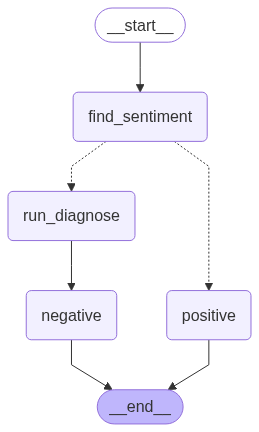

In [134]:
workflow

In [136]:
initial_state={"review":"The software id Good and i want to use more "}
workflow.invoke(initial_state)

{'review': 'The software id Good and i want to use more ',
 'sentiment': 'positive',
 'response': 'Okay, here are a few options, ranging from brief to slightly more detailed, all with a warm and appreciative tone:\n\n**Option 1 (Short & Sweet):**\n\n> Thank you so much for your positive feedback! We\'re glad you\'re enjoying the software and want to use it more. We\'ll be sure to reply to you on our website shortly.\n\n**Option 2 (Slightly More Engaging):**\n\n> We really appreciate your kind words! It\'s great to hear you\'re finding the software good and want to explore its full potential. We\'ll be in touch with you through our website very soon. Thanks again!\n\n**Option 3 (A Bit More Personal):**\n\n> Thank you for taking the time to leave us a review! We\'re thrilled you\'re having a positive experience with the software and are interested in using it further. We value your feedback and will definitely reach out to you on our website to answer any questions you may have.\n\n**Opt